# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [926]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',False)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, r2_score
import xgboost as xgb
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS

In [927]:
#LOADING THE TRAINING DATA

In [928]:
df_flights2 = pd.read_csv('/Users/annajose/Downloads/final_cleaned_flights.csv')

In [929]:
df_flights2.head()

,Unnamed: 0,fl_date,mkt_unique_carrier,mkt_carrier,origin_airport_id,origin,dest_airport_id,dest,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_delay,crs_elapsed_time,air_time,distance,carrier_delay,nas_delay
0,2,2019-04-14,F9,F9,15356,TTN,13204,MCO,1435,1541.0,66.0,1719,62.0,164.0,133.0,896.0,12.0,45.0
1,12,2018-06-09,UA,UA,13930,ORD,13342,MKE,1220,1428.0,128.0,1317,122.0,57.0,17.0,67.0,0.0,0.0
2,20,2018-08-26,AA,AA,11278,DCA,14100,PHL,1520,1558.0,38.0,1628,49.0,68.0,35.0,119.0,0.0,11.0
3,23,2018-08-30,F9,F9,11292,DEN,13495,MSY,600,626.0,26.0,940,27.0,160.0,130.0,1062.0,26.0,1.0
4,26,2019-08-21,AA,AA,10990,CHO,13930,ORD,1829,1936.0,67.0,1934,58.0,125.0,87.0,566.0,0.0,0.0


In [930]:
df_flights2.columns

Index(['Unnamed: 0', 'fl_date', 'mkt_unique_carrier', 'mkt_carrier',
       'origin_airport_id', 'origin', 'dest_airport_id', 'dest',
       'crs_dep_time', 'dep_time', 'dep_delay', 'crs_arr_time', 'arr_delay',
       'crs_elapsed_time', 'air_time', 'distance', 'carrier_delay',
       'nas_delay'],
      dtype='object')

In [931]:
df_flights2 = df_flights2.drop(columns=["Unnamed: 0"])

In [932]:
# TURNS DATE INTO MONTHS
df_flights2['fl_date'] = df_flights2['fl_date'].str[5:7]
df_flights2['fl_date'] = df_flights2['fl_date'].astype(int)

In [933]:
df_flights2

,fl_date,mkt_unique_carrier,mkt_carrier,origin_airport_id,origin,dest_airport_id,dest,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_delay,crs_elapsed_time,air_time,distance,carrier_delay,nas_delay
0,4,F9,F9,15356,TTN,13204,MCO,1435,1541.0,66.0,1719,62.0,164.0,133.0,896.0,12.0,45.0
1,6,UA,UA,13930,ORD,13342,MKE,1220,1428.0,128.0,1317,122.0,57.0,17.0,67.0,0.0,0.0
2,8,AA,AA,11278,DCA,14100,PHL,1520,1558.0,38.0,1628,49.0,68.0,35.0,119.0,0.0,11.0
3,8,F9,F9,11292,DEN,13495,MSY,600,626.0,26.0,940,27.0,160.0,130.0,1062.0,26.0,1.0
4,8,AA,AA,10990,CHO,13930,ORD,1829,1936.0,67.0,1934,58.0,125.0,87.0,566.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,8,DL,DL,13487,MSP,12884,LAN,2040,2034.0,-6.0,2320,35.0,100.0,92.0,455.0,0.0,35.0
552,7,AA,AA,14107,PHX,14831,SJC,1349,1451.0,62.0,1534,64.0,105.0,83.0,621.0,0.0,2.0
553,4,UA,UA,12266,IAH,15370,TUL,1432,1502.0,30.0,1608,24.0,96.0,69.0,429.0,24.0,0.0
554,5,DL,DL,13487,MSP,14771,SFO,855,1005.0,70.0,1117,57.0,262.0,222.0,1589.0,0.0,55.0


In [934]:
df_flights2 = df_flights2.drop(columns=["mkt_carrier"])

In [935]:
def flight_speed_feature(df_flights2):
    df_flights2_cp = df_flights2.copy()

    if ("cancelled" in df_flights2):
        df_flights2_cp['distance'] = df_flights2_cp.apply(
            lambda x: (0.0 if ((x['cancelled'] == 1) | (x['diverted'] == 1)) else x['distance']
                  ),  axis=1)
    
        df_flights2_cp['crs_elapsed_time'] = df_flights2_cp.apply(
            lambda x: (60.0 if ((x['cancelled'] == 1) | (x['diverted'] == 1)) else x['crs_elapsed_time']
                  ),  axis=1)
    
    return df_flights2_cp.apply(
        lambda x: ((x['distance'] / (x['crs_elapsed_time']/60)
              )),  axis=1)

In [936]:
df_flights2['flight_speed'] = flight_speed_feature(df_flights2)
df_flights2.head()

,fl_date,mkt_unique_carrier,origin_airport_id,origin,dest_airport_id,dest,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_delay,crs_elapsed_time,air_time,distance,carrier_delay,nas_delay,flight_speed
0,4,F9,15356,TTN,13204,MCO,1435,1541.0,66.0,1719,62.0,164.0,133.0,896.0,12.0,45.0,327.804878
1,6,UA,13930,ORD,13342,MKE,1220,1428.0,128.0,1317,122.0,57.0,17.0,67.0,0.0,0.0,70.526316
2,8,AA,11278,DCA,14100,PHL,1520,1558.0,38.0,1628,49.0,68.0,35.0,119.0,0.0,11.0,105.000000
3,8,F9,11292,DEN,13495,MSY,600,626.0,26.0,940,27.0,160.0,130.0,1062.0,26.0,1.0,398.250000
4,8,AA,10990,CHO,13930,ORD,1829,1936.0,67.0,1934,58.0,125.0,87.0,566.0,0.0,0.0,271.680000


In [937]:
#Flight Haul Type (values of 0, 1 and 2 for Short, Medium and Long)

In [938]:
def flight_haul_type_feature(df_flights2):
    df_flights2_cp = df_flights2.copy()
    
    if ("cancelled" in df_flights2):
        df_flights2_cp['crs_elapsed_time'] = df_flights2_cp.apply(
            lambda x: (0 if ((x['cancelled'] == 1) | (x['diverted'] == 1)) else x['crs_elapsed_time']
                  ),  axis=1)
    
    return df_flights2_cp.apply(
        lambda x: 0 if x['crs_elapsed_time'] <= 180.0 else (2 if x['crs_elapsed_time'] >= 360.0 else 1), axis=1
)

In [939]:
df_flights2['flight_haul_type'] = flight_haul_type_feature(df_flights2)
df_flights2.head()

,fl_date,mkt_unique_carrier,origin_airport_id,origin,dest_airport_id,dest,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_delay,crs_elapsed_time,air_time,distance,carrier_delay,nas_delay,flight_speed,flight_haul_type
0,4,F9,15356,TTN,13204,MCO,1435,1541.0,66.0,1719,62.0,164.0,133.0,896.0,12.0,45.0,327.804878,0
1,6,UA,13930,ORD,13342,MKE,1220,1428.0,128.0,1317,122.0,57.0,17.0,67.0,0.0,0.0,70.526316,0
2,8,AA,11278,DCA,14100,PHL,1520,1558.0,38.0,1628,49.0,68.0,35.0,119.0,0.0,11.0,105.000000,0
3,8,F9,11292,DEN,13495,MSY,600,626.0,26.0,940,27.0,160.0,130.0,1062.0,26.0,1.0,398.250000,0
4,8,AA,10990,CHO,13930,ORD,1829,1936.0,67.0,1934,58.0,125.0,87.0,566.0,0.0,0.0,271.680000,0


In [940]:
#Arrival hour of day 

In [941]:
def arrival_hour_of_day_feature(df_flights2):
    df_flights2_cp = df_flights2.copy()
    
    return df_flights2_cp[df_flights2_cp['crs_arr_time'].notna()].apply(
        lambda x: 0 if x['crs_arr_time'] == 2400.0 else datetime.strptime(str(int(x['crs_arr_time'])).zfill(4), '%H%M').time().hour, axis=1)

In [942]:
df_flights2['arrival_hour_of_day'] = arrival_hour_of_day_feature(df_flights2)
df_flights2.head()

,fl_date,mkt_unique_carrier,origin_airport_id,origin,dest_airport_id,dest,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_delay,crs_elapsed_time,air_time,distance,carrier_delay,nas_delay,flight_speed,flight_haul_type,arrival_hour_of_day
0,4,F9,15356,TTN,13204,MCO,1435,1541.0,66.0,1719,62.0,164.0,133.0,896.0,12.0,45.0,327.804878,0,17
1,6,UA,13930,ORD,13342,MKE,1220,1428.0,128.0,1317,122.0,57.0,17.0,67.0,0.0,0.0,70.526316,0,13
2,8,AA,11278,DCA,14100,PHL,1520,1558.0,38.0,1628,49.0,68.0,35.0,119.0,0.0,11.0,105.000000,0,16
3,8,F9,11292,DEN,13495,MSY,600,626.0,26.0,940,27.0,160.0,130.0,1062.0,26.0,1.0,398.250000,0,9
4,8,AA,10990,CHO,13930,ORD,1829,1936.0,67.0,1934,58.0,125.0,87.0,566.0,0.0,0.0,271.680000,0,19


In [943]:
#Dep hour of day (0 to 23)

In [944]:
def departure_hour_of_day_feature(df_flights2):
    df_flights2_cp = df_flights2.copy()
    
    return df_flights2_cp[df_flights2_cp['crs_dep_time'].notna()].apply(
        lambda x: 0 if x['crs_dep_time'] == 2400.0 else datetime.strptime(str(int(x['crs_dep_time'])).zfill(4), '%H%M').time().hour, axis=1)

In [945]:
df_flights2['departure_hour_of_day'] = departure_hour_of_day_feature(df_flights2)
df_flights2.head()

,fl_date,mkt_unique_carrier,origin_airport_id,origin,dest_airport_id,dest,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_delay,crs_elapsed_time,air_time,distance,carrier_delay,nas_delay,flight_speed,flight_haul_type,arrival_hour_of_day,departure_hour_of_day
0,4,F9,15356,TTN,13204,MCO,1435,1541.0,66.0,1719,62.0,164.0,133.0,896.0,12.0,45.0,327.804878,0,17,14
1,6,UA,13930,ORD,13342,MKE,1220,1428.0,128.0,1317,122.0,57.0,17.0,67.0,0.0,0.0,70.526316,0,13,12
2,8,AA,11278,DCA,14100,PHL,1520,1558.0,38.0,1628,49.0,68.0,35.0,119.0,0.0,11.0,105.000000,0,16,15
3,8,F9,11292,DEN,13495,MSY,600,626.0,26.0,940,27.0,160.0,130.0,1062.0,26.0,1.0,398.250000,0,9,6
4,8,AA,10990,CHO,13930,ORD,1829,1936.0,67.0,1934,58.0,125.0,87.0,566.0,0.0,0.0,271.680000,0,19,18


In [946]:
df_flights2.columns

Index(['fl_date', 'mkt_unique_carrier', 'origin_airport_id', 'origin',
       'dest_airport_id', 'dest', 'crs_dep_time', 'dep_time', 'dep_delay',
       'crs_arr_time', 'arr_delay', 'crs_elapsed_time', 'air_time', 'distance',
       'carrier_delay', 'nas_delay', 'flight_speed', 'flight_haul_type',
       'arrival_hour_of_day', 'departure_hour_of_day'],
      dtype='object')

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [947]:
#(FEATURED ON ANOTHER NOTEBOOK)

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [948]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [949]:
#one_hot = pd.get_dummies(df_flights2[['crs_dep_bin','crs_arr_bin']])


In [950]:
#df_flights2 = pd.concat([df_flights2,one_hot],axis=1)

In [951]:
#df_flights2

In [952]:
#df_flights2 = df_flights2.drop(['op_unique_carrier','origin','dest','origin','dest','fl_date','date_time','location','crs_dep_bin','crs_arr_bin'],axis=1)

In [953]:
#df_flights2

In [954]:
df_flights2 = df_flights2.drop(columns=["dep_delay", "carrier_delay", "nas_delay"])

In [955]:
#Make samples

In [956]:
X_train_sample = pd.DataFrame(X_train).sample(frac = 0.1).values

In [957]:
y_train_sample = pd.DataFrame(y_train).sample(frac = 0.1).values

In [958]:
y_trainCat_sample = pd.DataFrame(y_train_cat).sample(frac = 0.1).values

In [959]:
X_test_sample = pd.DataFrame(X_test).sample(frac = 0.1).values

In [960]:
#make types ordinal
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, PolynomialFeatures, MinMaxScaler, OneHotEncoder

# ENCODE
encoder = OrdinalEncoder()
df_flights2['mkt_unique_carrier'] = encoder.fit_transform(df_flights2[['mkt_unique_carrier']])
df_flights2['origin'] = encoder.fit_transform(df_flights2[['origin']])
df_flights2['dest'] = encoder.fit_transform(df_flights2[['dest']])
df_flights2['origin_airport_id'] = encoder.fit_transform(df_flights2[['origin_airport_id']])
df_flights2['dest_airport_id'] = encoder.fit_transform(df_flights2[['dest_airport_id']])


#df_flights2["mkt_unique_carrier"] = df_flights2["mkt_unique_carrier"].astype("category")
#df_flights2["origin_airport_id"] = df_flights2["origin_airport_id"].astype("category")
#df_flights2["dest_airport_id"] = df_flights2["dest_airport_id"].astype("category")

In [961]:
#make arr delay categorical 
df_flights2['arr_delay_cat'] = df_flights2['arr_delay'].apply(lambda x: 1 if x > 0 else 0)

In [962]:
X = df_flights2.drop(['arr_delay'],axis=1)
y = df_flights2['arr_delay']

In [963]:
X

,fl_date,mkt_unique_carrier,origin_airport_id,origin,dest_airport_id,dest,crs_dep_time,dep_time,crs_arr_time,crs_elapsed_time,air_time,distance,flight_speed,flight_haul_type,arrival_hour_of_day,departure_hour_of_day,arr_delay_cat
0,4,4.0,131.0,131.0,76.0,76.0,1435,1541.0,1719,164.0,133.0,896.0,327.804878,0,17,14,1
1,6,8.0,93.0,93.0,83.0,83.0,1220,1428.0,1317,57.0,17.0,67.0,70.526316,0,13,12,1
2,8,0.0,34.0,34.0,98.0,98.0,1520,1558.0,1628,68.0,35.0,119.0,105.000000,0,16,15,1
3,8,4.0,35.0,35.0,87.0,87.0,600,626.0,940,160.0,130.0,1062.0,398.250000,0,9,6,1
4,8,0.0,21.0,21.0,93.0,93.0,1829,1936.0,1934,125.0,87.0,566.0,271.680000,0,19,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,8,3.0,86.0,86.0,66.0,66.0,2040,2034.0,2320,100.0,92.0,455.0,273.000000,0,23,20,1
552,7,0.0,99.0,99.0,121.0,121.0,1349,1451.0,1534,105.0,83.0,621.0,354.857143,0,15,13,1
553,4,8.0,57.0,57.0,133.0,133.0,1432,1502.0,1608,96.0,69.0,429.0,268.125000,0,16,14,1
554,5,3.0,86.0,86.0,119.0,119.0,855,1005.0,1117,262.0,222.0,1589.0,363.893130,1,11,8,1


In [964]:
y

0       62.0
1      122.0
2       49.0
3       27.0
4       58.0
       ...  
551     35.0
552     64.0
553     24.0
554     57.0
555     41.0
Name: arr_delay, Length: 556, dtype: float64

In [965]:
df_flights2 = df_flights2.drop(columns=["origin", "dest", "dep_time", "arr_delay"])

In [966]:
df_flights2

,fl_date,mkt_unique_carrier,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,air_time,distance,flight_speed,flight_haul_type,arrival_hour_of_day,departure_hour_of_day,arr_delay_cat
0,4,4.0,131.0,76.0,1435,1719,164.0,133.0,896.0,327.804878,0,17,14,1
1,6,8.0,93.0,83.0,1220,1317,57.0,17.0,67.0,70.526316,0,13,12,1
2,8,0.0,34.0,98.0,1520,1628,68.0,35.0,119.0,105.000000,0,16,15,1
3,8,4.0,35.0,87.0,600,940,160.0,130.0,1062.0,398.250000,0,9,6,1
4,8,0.0,21.0,93.0,1829,1934,125.0,87.0,566.0,271.680000,0,19,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,8,3.0,86.0,66.0,2040,2320,100.0,92.0,455.0,273.000000,0,23,20,1
552,7,0.0,99.0,121.0,1349,1534,105.0,83.0,621.0,354.857143,0,15,13,1
553,4,8.0,57.0,133.0,1432,1608,96.0,69.0,429.0,268.125000,0,16,14,1
554,5,3.0,86.0,119.0,855,1117,262.0,222.0,1589.0,363.893130,1,11,8,1


#### Random forest

In [967]:
#Scaling

In [968]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
X_scale = pd.DataFrame(X_scale,columns=X.columns)

In [969]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [970]:
rf = RandomForestRegressor(n_estimators=100)

In [971]:
rf.fit(X_train,y_train)

RandomForestRegressor()

In [972]:
y_pred = rf.predict(X_test)

In [973]:
y_pred.mean()

67.08381294964029

In [974]:
rf_rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print(rf_rmse)

45.21314409859787


In [975]:
metrics.r2_score(y_test,y_pred)

0.3815854104725842

In [976]:
y_pred.mean()

67.08381294964029

In [977]:
difference = y_pred-y_test

In [978]:
difference

409   -47.63
500    12.34
466     4.29
515    18.73
540    29.92
       ...  
140    21.74
402   -28.90
423    46.43
105   -65.85
541     9.53
Name: arr_delay, Length: 139, dtype: float64

In [979]:
rf_df = pd.DataFrame({'y_pred':y_pred,
                       'y_test':y_test,
                       'difference':difference})

In [980]:
rf_df.describe()

,y_pred,y_test,difference
count,139.000000,139.000000,139.000000
mean,67.083813,64.805755,2.278058
std,41.283391,57.702244,45.319030
min,26.600000,15.000000,-151.610000
25%,40.990000,21.000000,-18.900000
50%,52.620000,44.000000,10.840000
75%,77.595000,91.500000,24.745000
max,259.360000,341.000000,215.250000


In [981]:
rf_df.head(20)

,y_pred,y_test,difference
409,183.37,231.0,-47.63
500,35.34,23.0,12.34
466,54.29,50.0,4.29
515,37.73,19.0,18.73
540,56.92,27.0,29.92
424,52.62,25.0,27.62
235,40.30,20.0,20.30
40,64.61,18.0,46.61
464,55.13,20.0,35.13
367,122.07,149.0,-26.93


In [982]:
importance = rf.feature_importances_

Feature: 0, Score: 0.02661
Feature: 1, Score: 0.01456
Feature: 2, Score: 0.01727
Feature: 3, Score: 0.01845
Feature: 4, Score: 0.02786
Feature: 5, Score: 0.02644
Feature: 6, Score: 0.20900
Feature: 7, Score: 0.36191
Feature: 8, Score: 0.06111
Feature: 9, Score: 0.02339
Feature: 10, Score: 0.02325
Feature: 11, Score: 0.02950
Feature: 12, Score: 0.09393
Feature: 13, Score: 0.00070
Feature: 14, Score: 0.02353
Feature: 15, Score: 0.04250
Feature: 16, Score: 0.00000


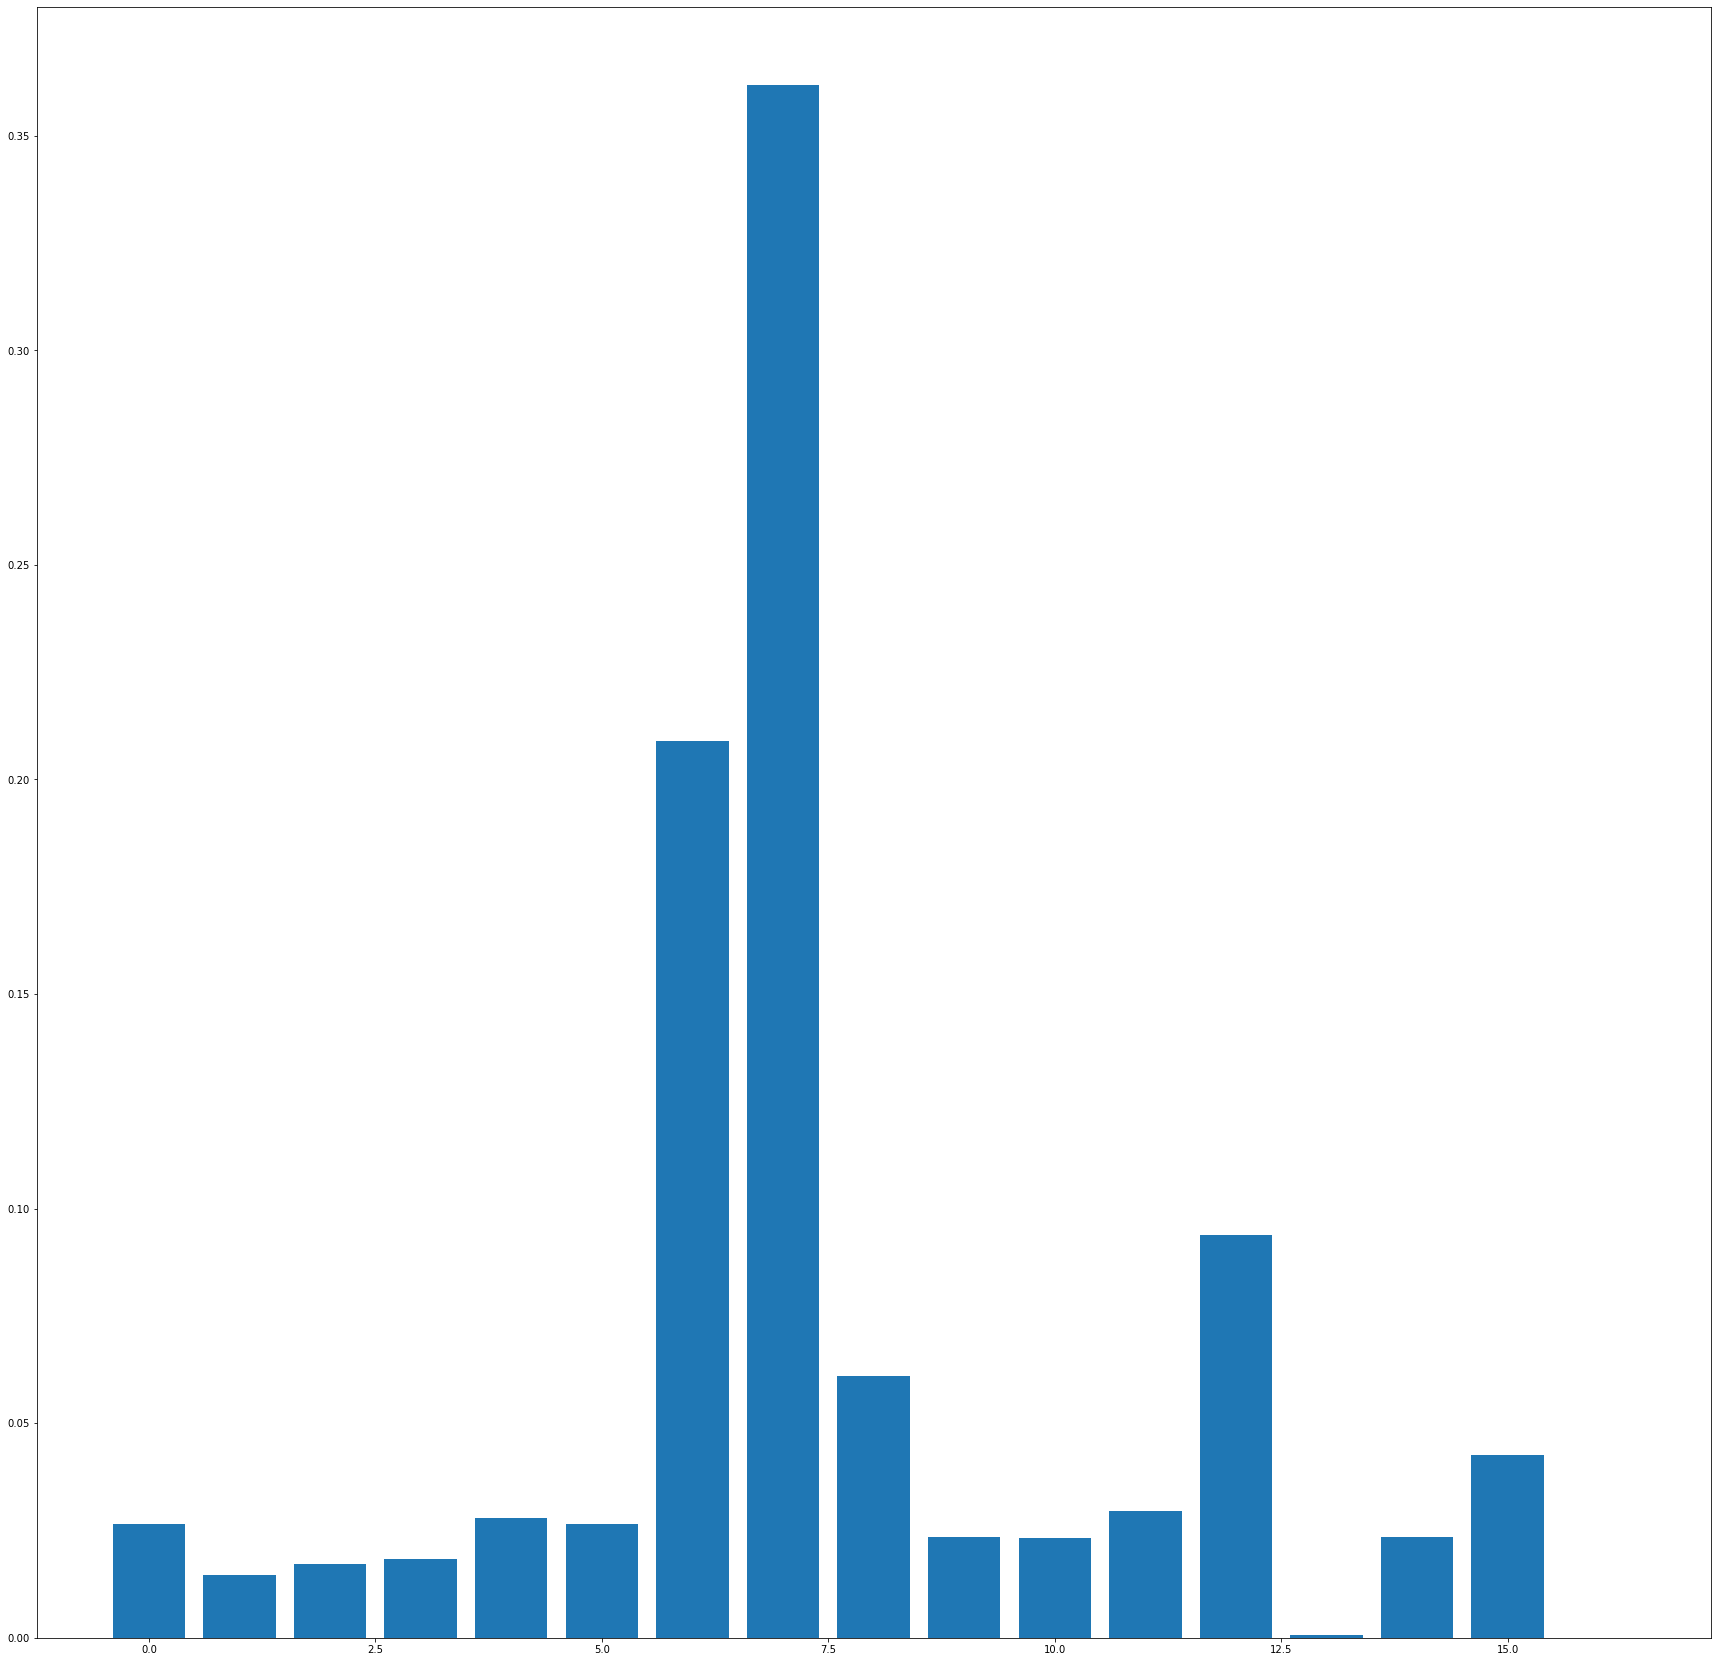

In [983]:
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

GridSearchCV

In [984]:
from sklearn.model_selection import GridSearchCV

In [985]:
params = {
    'n_estimators': [50,100,150,200,250,300],
    'max_depth': [1,3,5,7,9]
}
n=5

In [986]:
rf = RandomForestRegressor()

In [987]:
grid = GridSearchCV(estimator=rf,param_grid=params,cv=n,scoring='r2',verbose=1,n_jobs=-1)

In [988]:
grid_results = grid.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   40.7s finished


In [989]:
grid_pred = grid_results.predict(X_test)

In [990]:
best_score = grid_results.best_score_
best_params = grid_results.best_params_

In [991]:
#rmse = np.sqrt(mean_squared_error(y_test,grid_pred))
#print('RMSE: ',rmse)

In [992]:
r2_score(y_test,grid_pred)

0.29490652378858173

In [993]:
print('Best Score:',best_score)
print('Best Params:',best_params)

Best Score: 0.334617654769092
Best Params: {'max_depth': 9, 'n_estimators': 250}


In [994]:
grid_diff = grid_pred-y_test

grid_df = pd.DataFrame({'grid_pred':grid_pred,
                       'y_test':y_test,
                       'difference':grid_diff})

In [995]:
grid_df.head()

,grid_pred,y_test,difference
409,167.791810,231.0,-63.208190
500,46.716817,23.0,23.716817
466,58.028054,50.0,8.028054
515,44.859055,19.0,25.859055
540,64.043756,27.0,37.043756


In [996]:
grid_df.describe()

,grid_pred,y_test,difference
count,139.000000,139.000000,139.000000
mean,64.938679,64.805755,0.132924
std,35.476679,57.702244,48.452301
min,34.049029,15.000000,-185.007407
25%,45.323570,21.000000,-24.841994
50%,53.043262,44.000000,9.552203
75%,68.390714,91.500000,26.769143
max,249.564913,341.000000,204.124617


In [997]:
##Random Forest Classifier

In [998]:
#from sklearn.ensemble import RandomForestClassifier

In [999]:
#random_forest_class = RandomForestClassifier()

In [1000]:
#hyperparameters ={
#    'rand_forrestClass__n_estimators': [8000, 10000],
#    'rand_forrestClass__max_depth': [10],
#    'rand_forrestClass__bootstrap': [False]
#}

In [1001]:
#Forest_class_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('rand_forrestClass', RandomForestClassifier())])
#forest_class_grid = GridSearchCV(estimator=Forest_class_pipe, param_grid=hyperparameters, scoring = 'r2', verbose=0, cv= 5)

In [1002]:
#forest_class_grid.best_estimator_



XGB

In [1003]:
import xgboost as xgb

In [1004]:
#data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 454 to 330
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fl_date                417 non-null    int64  
 1   mkt_unique_carrier     417 non-null    float64
 2   origin_airport_id      417 non-null    float64
 3   origin                 417 non-null    float64
 4   dest_airport_id        417 non-null    float64
 5   dest                   417 non-null    float64
 6   crs_dep_time           417 non-null    int64  
 7   dep_time               417 non-null    float64
 8   crs_arr_time           417 non-null    int64  
 9   crs_elapsed_time       417 non-null    float64
 10  air_time               417 non-null    float64
 11  distance               417 non-null    float64
 12  flight_speed           417 non-null    float64
 13  flight_haul_type       417 non-null    int64  
 14  arrival_hour_of_day    417 non-null    int64  
 15  depa

In [1005]:
xg_reg = xgb.XGBRegressor(objective='reg:linear',colsample_bytree = 0.3, learning_rate = 0.1, max_depth=9,alpha=10,n_estimators=250)

In [1006]:
xg_reg.fit(X_train,y_train)

[23:19:59] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=250, n_jobs=4, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [1007]:
xg_pred = xg_reg.predict(X_test)

In [1055]:
xg_pred.mean()

64.41801

In [1008]:
rmse = np.sqrt(mean_squared_error(y_test,xg_pred))
print('RMSE: ',rmse)

RMSE:  49.59354322104538


In [1009]:
xgb_diff = xg_pred-y_test

xgb_df = pd.DataFrame({'xg_pred':xg_pred,
                       'y_test':y_test,
                       'difference':xgb_diff})

In [1010]:
xgb_df.head()

,xg_pred,y_test,difference
409,94.498283,231.0,-136.501717
500,40.792896,23.0,17.792896
466,35.128452,50.0,-14.871548
515,25.972940,19.0,6.972940
540,113.870811,27.0,86.870811


In [1011]:
metrics.r2_score(y_test,xg_pred)

0.25595263199008955

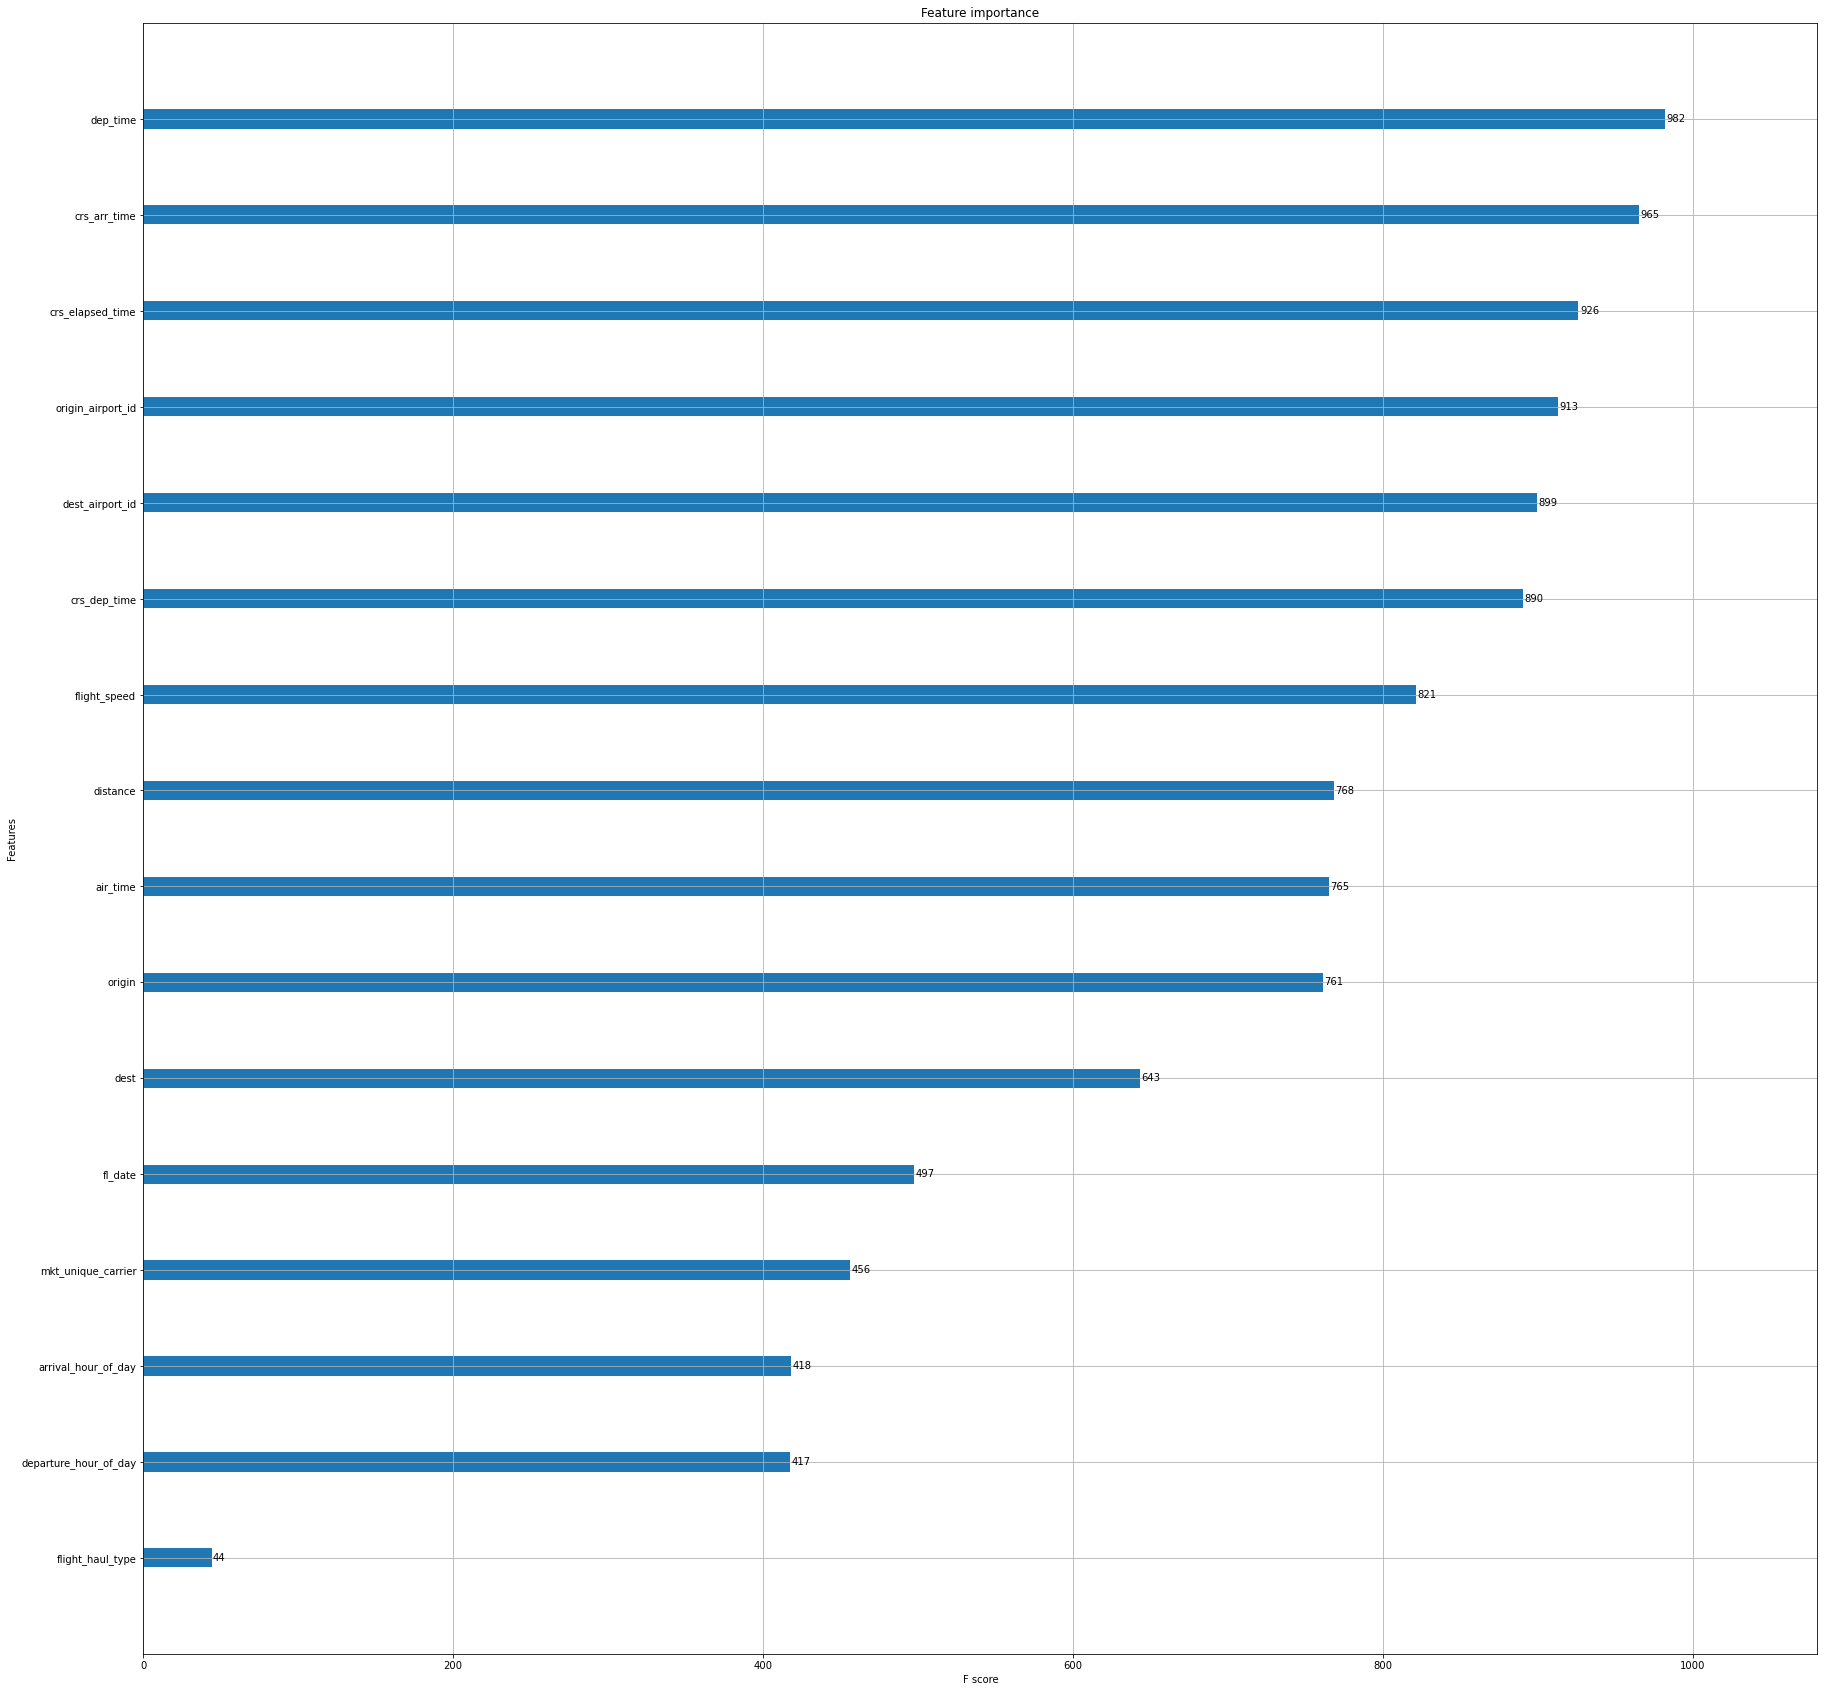

In [1012]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [30, 30]
plt.show()

In [1013]:
print(rf_df.describe())
print("\n")
print(grid_df.describe())
print("\n")
print(xgb_df.describe())

           y_pred      y_test  difference
count  139.000000  139.000000  139.000000
mean    67.083813   64.805755    2.278058
std     41.283391   57.702244   45.319030
min     26.600000   15.000000 -151.610000
25%     40.990000   21.000000  -18.900000
50%     52.620000   44.000000   10.840000
75%     77.595000   91.500000   24.745000
max    259.360000  341.000000  215.250000


        grid_pred      y_test  difference
count  139.000000  139.000000  139.000000
mean    64.938679   64.805755    0.132924
std     35.476679   57.702244   48.452301
min     34.049029   15.000000 -185.007407
25%     45.323570   21.000000  -24.841994
50%     53.043262   44.000000    9.552203
75%     68.390714   91.500000   26.769143
max    249.564913  341.000000  204.124617


          xg_pred      y_test  difference
count  139.000000  139.000000  139.000000
mean    64.418015   64.805755   -0.387749
std     25.105192   57.702244   49.771384
min     13.549000   15.000000 -220.939980
25%     47.971329   21.000000 

In [1014]:
#Scaling pipe

In [1015]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [1016]:
pipe = Pipeline([('scaler', StandardScaler())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler())])

In [1017]:
#Linear

In [1018]:
#Introducing the target and features

In [1025]:
#y = np.array(df_flights2.arr_delay_cat)

In [1026]:
y_cat = np.array(df_flights2.arr_delay_cat)

In [1028]:
#X_df

In [1029]:
#X_df = df_flights2.drop(['arr_delay', 'arr_delay_cat'], axis = 1)

In [1031]:
X = np.array(X_df)

In [1032]:
#Train test split

In [1033]:
import sklearn.model_selection as model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.70,test_size=0.30, random_state=101, shuffle = True)

In [1034]:
#creating y_train_cat and y_test_cat
X_train, X_test, y_train_cat, y_test_cat = model_selection.train_test_split(X, y_cat, train_size=0.70,test_size=0.30, random_state=101, shuffle = True)

In [1035]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [1036]:
#logistic regression
linear_model = LinearRegression()

In [1037]:
linear_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('linear_model', LinearRegression())])

In [1038]:
linear_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_model', LinearRegression())])

In [1039]:
y_pred_linear = linear_pipe.predict(X_test)

In [1053]:
y_pred_linear.mean()

1.0

In [1040]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred_linear))
print('RMSE: ',rmse)

RMSE:  0.0


In [1041]:
r2_score = linear_pipe.score(X_test, y_test)

In [1042]:
r2_score

1.0

In [1043]:
#Naives Bayes, GaussianNB Naive Bayes

In [1044]:
from sklearn.naive_bayes import GaussianNB

In [1045]:
NB_Gauss_model = GaussianNB()

In [1046]:
NB_Gauss_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('NB_Gauss_model', GaussianNB())])

In [1047]:
NB_Gauss_pipe.fit(X_train, y_train_cat)

Pipeline(steps=[('scaler', StandardScaler()), ('NB_Gauss_model', GaussianNB())])

In [1048]:
y_pred_NBGauss = NB_Gauss_pipe.predict(X_test)

In [1054]:
y_pred_NBGauss.mean()

1.0

In [1050]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred_NBGauss))
print('RMSE: ',rmse)

RMSE:  0.0


In [1051]:
r2_score = NB_Gauss_pipe.score(X_test, y_test_cat)
r2_score

1.0

In [ ]:
#SVM

In [ ]:
from sklearn.svm import SVC, SVR, LinearSVC

In [ ]:
model_svm_class = SVC()

In [ ]:
hyperparameters = {'model_svm_class__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                   'model_svm_class__C':[1, 2, 3, 4],
                   'model_svm_class__degree':[1,2,3]
}
SVC_grid_class = GridSearchCV(estimator=model_svm_class, param_grid=hyperparameters, scoring = 'r2', verbose=0, cv= 5)

In [ ]:
svm_class_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('model_svm_class', SVC())])
smv_class_grid = GridSearchCV(estimator=svm_class_pipe, param_grid=hyperparameters, scoring = 'r2', verbose=0, cv= 5)

In [ ]:
#test with sample to get best parameters

In [ ]:
#smv_class_grid.fit(X_train_sample, y_trainCat_sample.ravel())
#y_pred_svm = smv_class_grid.predict(X_test_sample)

In [ ]:
#smv_class_grid.best_estimator_

In [ ]:
#Adjusted to best hyperparameters

In [ ]:
#smv_class_grid.fit(X_train,y_train_cat)
#y_pred_svc_cat = smv_class_grid.predict(X_test)

In [ ]:
smv_class_grid.best_estimator

In [ ]:
r2_score(y_test_cat, y_pred_svc_cat)

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.